## Gas Sensor Array Drift - Modeling

In [103]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import time

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt


In [104]:
seed = 10

### Load the data

In [105]:
dataset = pd.read_csv('dataset_new.csv')

In [106]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
11,13910.0,-0.854016,0.152239,-1.0,-0.963341,-0.904241,-0.802275,1.0
15,13910.0,0.814373,0.154773,-1.0,0.829059,0.857843,0.876448,1.0
16,13910.0,-0.177983,0.244992,-1.0,-0.365460,-0.213577,-0.031182,1.0
25,13910.0,-0.924911,0.061348,-1.0,-0.964990,-0.941293,-0.908077,1.0
27,13910.0,-0.971436,0.034259,-1.0,-0.989647,-0.978693,-0.960992,1.0
35,13910.0,-0.937673,0.044303,-1.0,-0.964819,-0.945350,-0.918781,1.0
36,13910.0,-0.977512,0.022682,-1.0,-0.983925,-0.979407,-0.972593,1.0
42,13910.0,-0.889185,0.065573,-1.0,-0.932492,-0.902693,-0.859333,1.0
67,13910.0,-0.798513,0.228608,-1.0,-0.960318,-0.879118,-0.713677,1.0
68,13910.0,-0.869138,0.150393,-1.0,-0.966523,-0.912061,-0.831908,1.0


In [107]:
# drop rows with missing values
dataset.dropna(inplace=True)
print(dataset.shape)

(13910, 27)


In [108]:
dataset.isnull().sum()

11        0
15        0
16        0
25        0
27        0
35        0
36        0
42        0
67        0
68        0
69        0
70        0
71        0
76        0
77        0
78        0
81        0
85        0
87        0
88        0
100       0
104       0
105       0
115       0
116       0
123       0
target    0
dtype: int64

In [109]:
dataset.target.unique()

array([1, 2, 3, 4, 5, 6])

In [110]:
print(dataset.shape)
dataset.head()

(13910, 27)


,11,15,16,25,27,35,36,42,67,68,...,85,87,88,100,104,105,115,116,123,target
0,-0.983235,0.880771,-0.465786,-0.965757,-0.998345,-0.996478,-0.998516,-0.986391,-0.970262,-0.968339,...,0.961107,0.958817,-0.727604,-0.993608,-0.743961,-0.830349,-0.983651,-0.989825,-0.995176,1
1,-0.962950,0.878272,-0.442325,-0.959520,-0.996986,-0.993518,-0.997962,-0.975004,-0.938728,-0.967645,...,0.935384,0.960165,-0.704714,-0.996111,-0.698075,-0.790407,-0.963147,-0.986838,-0.989122,1
2,-0.940908,0.875730,-0.408138,-0.949129,-0.995487,-0.989789,-0.997069,-0.963492,-0.902022,-0.950903,...,0.901869,0.955267,-0.670622,-0.990856,-0.631462,-0.723606,-0.943451,-0.980710,-0.983409,1
3,-0.909435,0.875197,-0.403969,-0.947990,-0.992739,-0.984775,-0.995475,-0.948086,-0.846068,-0.852793,...,0.895511,0.956006,-0.666491,-0.990730,-0.619449,-0.709701,-0.918075,-0.972499,-0.976055,1
4,-0.910599,0.871636,-0.365080,-0.933673,-0.993158,-0.984050,-0.995536,-0.947605,-0.851349,-0.931227,...,0.857691,0.951931,-0.627637,-0.991723,-0.546051,-0.625176,-0.911484,-0.970903,-0.974309,1


In [245]:
dataset.columns

Index(['11', '15', '16', '25', '27', '35', '36', '42', '67', '68', '69', '70',
       '71', '76', '77', '78', '81', '85', '87', '88', '100', '104', '105',
       '115', '116', '123', 'target'],
      dtype='object')

## Correlation

In [166]:
cor = dataset.corr()
cor

,11,15,16,25,27,35,36,42,67,68,...,85,87,88,100,104,105,115,116,123,target
11,1.000000,-0.631851,0.494791,0.268800,0.041448,0.333237,0.119643,0.508382,0.948035,0.878325,...,-0.530108,-0.423808,0.581690,0.164247,0.553355,0.282909,0.187080,0.181915,0.213978,0.309404
15,-0.631851,1.000000,-0.426286,-0.350825,-0.044916,-0.203820,-0.079536,-0.361040,-0.643835,-0.712399,...,0.617541,0.797904,-0.475605,-0.089455,-0.377884,-0.351170,-0.183909,-0.204923,-0.193276,-0.224890
16,0.494791,-0.426286,1.000000,0.745535,0.529471,0.572159,0.239898,0.748839,0.504349,0.480899,...,-0.903263,-0.577458,0.977565,0.413728,0.875581,0.655866,0.797374,0.768137,0.787203,-0.196012
25,0.268800,-0.350825,0.745535,1.000000,0.511423,0.556256,0.382421,0.657826,0.331112,0.316122,...,-0.695724,-0.487211,0.718061,0.373299,0.635610,0.800193,0.631756,0.618211,0.656071,-0.243607
27,0.041448,-0.044916,0.529471,0.511423,1.000000,0.527566,0.423027,0.473273,0.046465,0.028961,...,-0.496871,-0.294295,0.534215,0.507766,0.455078,0.357687,0.711968,0.716926,0.728400,-0.354290
35,0.333237,-0.203820,0.572159,0.556256,0.527566,1.000000,0.736382,0.883513,0.389126,0.335283,...,-0.558221,-0.356924,0.576593,0.756476,0.669656,0.536903,0.616782,0.599641,0.683449,-0.340157
36,0.119643,-0.079536,0.239898,0.382421,0.423027,0.736382,1.000000,0.465014,0.147643,0.141619,...,-0.251640,-0.171477,0.254437,0.793552,0.285419,0.240237,0.320625,0.346772,0.440024,-0.174680
42,0.508382,-0.361040,0.748839,0.657826,0.473273,0.883513,0.465014,1.000000,0.554910,0.485596,...,-0.701559,-0.466754,0.749846,0.572101,0.885193,0.744298,0.620885,0.589397,0.654200,-0.254005
67,0.948035,-0.643835,0.504349,0.331112,0.046465,0.389126,0.147643,0.554910,1.000000,0.934320,...,-0.536448,-0.450447,0.576374,0.220567,0.561114,0.357732,0.231401,0.228128,0.263658,0.171308
68,0.878325,-0.712399,0.480899,0.316122,0.028961,0.335283,0.141619,0.485596,0.934320,1.000000,...,-0.500447,-0.509327,0.553680,0.185254,0.481821,0.328760,0.210502,0.228645,0.237345,0.210117


## Heatmap

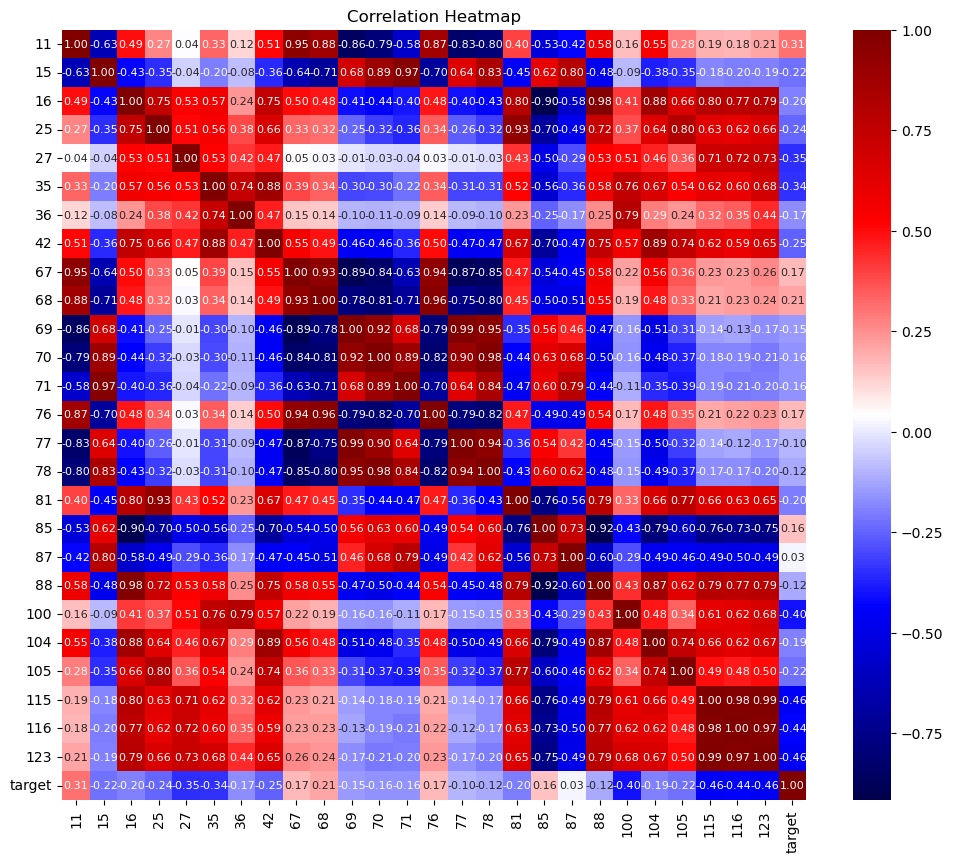

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))  # Increase figure size for better readability
sns.heatmap(cor, annot=True, cmap='seismic', fmt='.2f', annot_kws={"size": 8})  # Reduce annotation size
plt.title('Correlation Heatmap', fontsize=12)  # Reduce title font size
plt.show()


In [113]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   11      13910 non-null  float64
 1   15      13910 non-null  float64
 2   16      13910 non-null  float64
 3   25      13910 non-null  float64
 4   27      13910 non-null  float64
 5   35      13910 non-null  float64
 6   36      13910 non-null  float64
 7   42      13910 non-null  float64
 8   67      13910 non-null  float64
 9   68      13910 non-null  float64
 10  69      13910 non-null  float64
 11  70      13910 non-null  float64
 12  71      13910 non-null  float64
 13  76      13910 non-null  float64
 14  77      13910 non-null  float64
 15  78      13910 non-null  float64
 16  81      13910 non-null  float64
 17  85      13910 non-null  float64
 18  87      13910 non-null  float64
 19  88      13910 non-null  float64
 20  100     13910 non-null  float64
 21  104     13910 non-null  float64
 22

## Data Separation

In [252]:
# Set y as the first column
y = dataset['11']

# Set X as all columns except '11' and 'target'
X = dataset.drop(columns=['11'])


In [253]:
X.shape

(13910, 26)

In [254]:
y.shape

(13910,)

In [255]:
X.head(1)

,15,16,25,27,35,36,42,67,68,69,...,85,87,88,100,104,105,115,116,123,target
0,0.880771,-0.465786,-0.965757,-0.998345,-0.996478,-0.998516,-0.986391,-0.970262,-0.968339,0.946258,...,0.961107,0.958817,-0.727604,-0.993608,-0.743961,-0.830349,-0.983651,-0.989825,-0.995176,1


In [256]:
y.head(1)

0   -0.983235
Name: 11, dtype: float64

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [258]:
X_train.shape, X_test.shape

((11128, 26), (2782, 26))

## Best Parameter Selection for ML ALgorithm /Regression


In [259]:
kfold = StratifiedKFold(n_splits=10, random_state=20, shuffle=True)

In [260]:
X_train.shape

(11128, 26)

In [261]:
y_train.shape

(11128,)

In [262]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [263]:
# Verify shapes of scaled data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (11128, 26)
X_test_scaled shape: (2782, 26)


## 1. MLP regression Model

In [264]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100)],  # Different hidden layer configurations
    'activation': ['relu', 'tanh'],  # Activation functions to try
    'alpha': [0.0001, 0.001, 0.01],   # Regularization parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

# Perform grid search with cross-validation (default 5 folds)
mlp_regressor = MLPRegressor(max_iter=500, random_state=42)
grid_search = GridSearchCV(mlp_regressor, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant'}


In [265]:
# Train the MLPRegressor model with the best parameters
best_mlp_regressor = MLPRegressor(max_iter=500, random_state=42, **best_params)

training_start = time.perf_counter()
best_mlp_regressor.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

# Evaluate the model
prediction_start = time.perf_counter()
y_pred_inverse = best_mlp_regressor.predict(X_test_scaled)
prediction_end = time.perf_counter()

mse_inverse = mean_squared_error(y_test, y_pred_inverse)
r2_inverse = r2_score(y_test, y_pred_inverse)
mlp_train_time = training_end - training_start
mlp_prediction_time = prediction_end - prediction_start


print(f"Inverse Model MSE: {mse_inverse:.4f}")
print(f"Inverse Model R^2: {r2_inverse:.4f}")
print("Time consumed for training: %4.3f seconds" % (mlp_train_time))
print("Time consumed for prediction: %6.5f seconds" % (mlp_prediction_time))

Inverse Model MSE: 0.0006
Inverse Model R^2: 0.9717
Time consumed for training: 0.785 seconds
Time consumed for prediction: 0.00235 seconds


In [267]:
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and fitted
# scaler and inverse_model are already fitted as per your previous steps

# Define new sensor measurements
new_sensor_measurements = np.array([[-0.9832349375094429, 0.8807709664663792, -0.4657861086935119, -0.9657571976043883, 
               -0.9983446563451752, -0.9964779315774628, -0.9985160912113946, -0.9863906447251681, 
               -0.9702616411543138, -0.9683387279220913, 0.9462577783644988, 0.8840254115022562, 
               0.8955487799096424, -0.9638578164032203, 0.9450192060341563, 0.8437455490621253, 
               -0.9066556921734326, 0.9611067907480276, 0.9588174063088759, -0.7276041491349691, 
               -0.9936077345379808, -0.7439608232087858, -0.8303485897876489, -0.9836507512030219, 
               -0.9898252206926107, -0.9951755028067416, 1]])
new_sensor_measurements = new_sensor_measurements[:, :-1]


# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the inverse model
predicted_X = best_mlp_regressor.predict(new_sensor_scaled)

print("Predicted True Measurements:", predicted_X)

Predicted True Measurements: [-0.86072298]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## 2. ElasticNet

In [227]:
param_grid_elasticnet = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  # Regularization parameter
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],     # L1 ratio (0 for L2 regularization, 1 for L1 regularization)
}

# Perform grid search with cross-validation (default 5 folds)
elasticnet_regressor = ElasticNet(random_state=42)
grid_search_elasticnet = GridSearchCV(elasticnet_regressor, param_grid_elasticnet, cv=10, scoring='r2', n_jobs=-1)
grid_search_elasticnet.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_elasticnet = grid_search_elasticnet.best_params_
print(f"Best parameters found: {best_params_elasticnet}")


Best parameters found: {'alpha': 0.0001, 'l1_ratio': 0.3}


In [228]:
best_elasticnet_regressor = ElasticNet(random_state=42, **best_params_elasticnet)

training_start_elasticnet = time.perf_counter()
best_elasticnet_regressor.fit(X_train_scaled, y_train)
training_end_elasticnet = time.perf_counter()

# Evaluate the model
prediction_start_elasticnet = time.perf_counter()
y_pred_test_elasticnet = best_elasticnet_regressor.predict(X_test_scaled)
prediction_end_elasticnet = time.perf_counter()

mse_test_elasticnet = mean_squared_error(y_test, y_pred_test_elasticnet)
r2_test_elasticnet = r2_score(y_test, y_pred_test_elasticnet)
elasticnet_train_time = training_end_elasticnet - training_start_elasticnet
elasticnet_pred_time = prediction_end_elasticnet - prediction_start_elasticnet

# Print evaluation metrics
print(f"ElasticNet Testing MSE: {mse_test_elasticnet:.4f}")
print(f"ElasticNet Testing R^2: {r2_test_elasticnet:.4f}")
print(f"ElasticNet Training Time: {elasticnet_train_time:.4f} seconds")
print(f"ElasticNet Prediction Time: {elasticnet_pred_time:.5f} seconds")


ElasticNet Testing MSE: 0.0008
ElasticNet Testing R^2: 0.9616
ElasticNet Training Time: 0.0916 seconds
ElasticNet Prediction Time: 0.00038 seconds


In [268]:
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and fitted
# scaler and inverse_model are already fitted as per your previous steps

new_sensor_measurements = np.array([[-0.9832349375094429, 0.8807709664663792, -0.4657861086935119, -0.9657571976043883, 
               -0.9983446563451752, -0.9964779315774628, -0.9985160912113946, -0.9863906447251681, 
               -0.9702616411543138, -0.9683387279220913, 0.9462577783644988, 0.8840254115022562, 
               0.8955487799096424, -0.9638578164032203, 0.9450192060341563, 0.8437455490621253, 
               -0.9066556921734326, 0.9611067907480276, 0.9588174063088759, -0.7276041491349691, 
               -0.9936077345379808, -0.7439608232087858, -0.8303485897876489, -0.9836507512030219, 
               -0.9898252206926107, -0.9951755028067416, 1]])
new_sensor_measurements = new_sensor_measurements[:, :-1]


# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the inverse model
predicted_X = best_elasticnet_regressor.predict(new_sensor_scaled)

print("Predicted True Measurements:", predicted_X)

Predicted True Measurements: [-0.1344785]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## 3. SVM

In [233]:
# Define the hyperparameter grid for grid search
param_grid = {
    'C': [2**i for i in range(-5, 11)],  # 2^-5 to 2^10
    'gamma': [2**i for i in range(-10, 6)]  # 2^-10 to 2^5
}

# Perform grid search with cross-validation (10 folds)
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'C': 32, 'gamma': 0.125}


In [234]:
# Train the SVR model with the best parameters
best_svr = SVR(kernel='rbf', C=32, gamma=best_params['gamma'])

training_start = time.perf_counter()
best_svr.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

training_end = time.perf_counter()

# Evaluate the model
prediction_start = time.perf_counter()
y_pred_test_svr = best_svr.predict(X_test_scaled)
prediction_end = time.perf_counter()


mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)
r2_test_svr = r2_score(y_test, y_pred_test_svr)
svm_train_time = training_end - training_start
svm_prediction_time = prediction_end - prediction_start

print(f"SVR Testing MSE: {mse_test_svr:.4f}")
print(f"SVR Testing R^2: {r2_test_svr:.4f}")
print("Time consumed for training: %4.3f seconds" % (svm_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svm_prediction_time))

SVR Testing MSE: 0.0016
SVR Testing R^2: 0.9242
Time consumed for training: 0.157 seconds
Time consumed for prediction: 0.00943 seconds


In [269]:
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and fitted
# scaler and inverse_model are already fitted as per your previous steps

# Define new sensor measurements
new_sensor_measurements = np.array([[-0.9832349375094429, 0.8807709664663792, -0.4657861086935119, -0.9657571976043883, 
               -0.9983446563451752, -0.9964779315774628, -0.9985160912113946, -0.9863906447251681, 
               -0.9702616411543138, -0.9683387279220913, 0.9462577783644988, 0.8840254115022562, 
               0.8955487799096424, -0.9638578164032203, 0.9450192060341563, 0.8437455490621253, 
               -0.9066556921734326, 0.9611067907480276, 0.9588174063088759, -0.7276041491349691, 
               -0.9936077345379808, -0.7439608232087858, -0.8303485897876489, -0.9836507512030219, 
               -0.9898252206926107, -0.9951755028067416, 1]])
new_sensor_measurements = new_sensor_measurements[:, :-1]


# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the inverse model
predicted_X = svr_regressor.predict(new_sensor_scaled)

print("Predicted True Measurements:", predicted_X)

Predicted True Measurements: [-0.61750406]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Report

| Model           | MSE    | R^2    | Training Time (s) | Prediction Time (s) | Predicted True Measurements |
|-----------------|--------|--------|--------------------|----------------------|-----------------------------|
| MLP Regression  | 0.0006 | 0.9717 | 0.713              | 0.00203              | -0.83301032                 |
| ElasticNet      | 0.0008 | 0.9616 | 0.0916             | 0.00038              | -0.15067784                 |
| SVR             | 0.0016 | 0.9242 | 0.157              | 0.00943              | -0.61833211                 |
